In [278]:
from audioFunctions import *
from binaryFunctions import *
from qam import *
from sequenceGenerators import *
from receiver import *
from to_import import *

In [279]:
CE_binary = fileToBinary('KisekiTesting/untitled.txt')
#binary = fileToBinary('Data_Files/homecoming.txt')

CE_symbols = qpsk(CE_binary)
#symbols = qpsk(binary)

In [280]:
# So far this works the best at estimating the location... 
chirp_signal = Chirp(500,20500,0.5, volume = 50)

In [281]:
# For channel esimation (CE)

# ofdmSymbols(encoded_symbols, CP_length, DFT_length, max_freq_index=0)
CE_Time, CE_Freq, CE_Long = ofdmSymbols(CE_symbols, 2048, 2048)

In [282]:
# Prepare what to transmit for channel estimation 
CE_transmit = repeat_signal(CE_Time[0], 20)
known_freq = CE_Freq[0]

In [288]:
pause_after_chirp = 0.25
sd.default.device = "Built-in Output"
sd.default.samplerate = 128000
x = save_transmit((chirp_signal, Pause(pause_after_chirp), CE_transmit, Pause(0.1)) , playOutput=True)
#x = save_transmit( (Pause(1), chirp_signal) ) #, Pause(pause_after_chirp) ) )
print("Transmit signal is ", round(len(x)/fs, 2), " seconds")

playing
['Built-in Output', 'Built-in Output']
[16383 16341 16216 ...     0     0     0]
Transmit signal is  2.71  seconds


In [329]:
# record for some seconds
sd.default.device = "Built-in Microphone"
sd.default.samplerate = 44100
y = record_and_save('KisekiTesting/recording128.wav', 6)

recording
['Built-in Microphone', 'Built-in Microphone']
writing
done


In [330]:
sec = math.ceil(len(x)/fs) + 4
location = 'workdesk'
#y = record_and_save('speakertolaptop.wav', sec)
#y = audioDataFromFile('recorded_data_' + location + '.wav')
y = audioDataFromFile('KisekiTesting/recording128.wav')

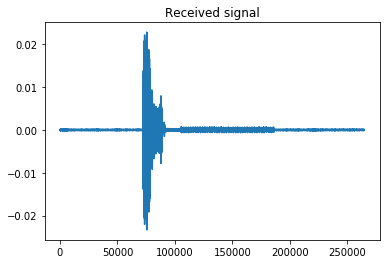

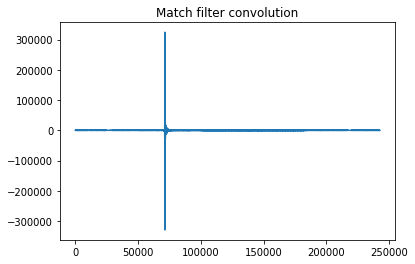

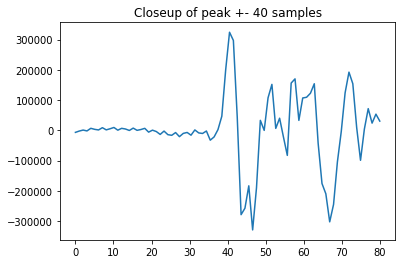

In [331]:
# obtain only the time series we are interested in 
y_dash = removeChirpAndPause(y, chirp_signal, pause_after_chirp, plot = True, rng = 40)

In [332]:
#sliceData(time_data, timeshift, N, K, repeat)
CE_samples, CE_freq, remaining = sliceData(y_dash, 2048, 2048, 2048, 20)


In [333]:

freq = []
for sample in CE_samples:
    freq.append( fft( np.roll(sample, 15) ) )


CE_time_adjusted_freq = np.array(freq)
impulse_simple_by_eye, TF_by_eye = getImpulseSimple(CE_time_adjusted_freq, known_freq, len(CE_freq[0]), len(CE_freq))



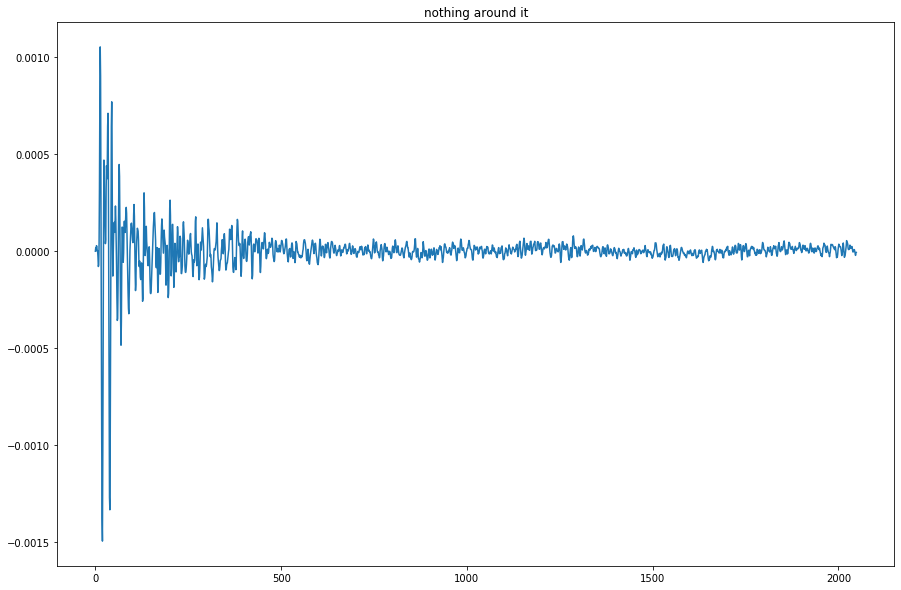

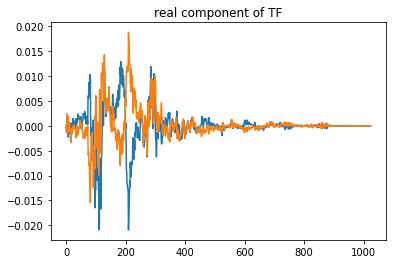

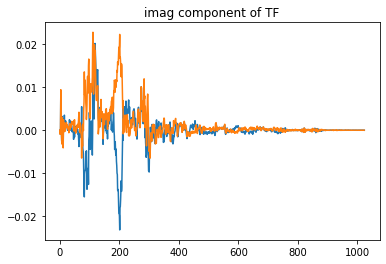

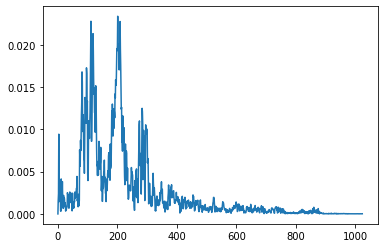

In [334]:
# getImpulseSimple(freq, known_freq, N, repeat)
impulse_simple, TF = getImpulseSimple(CE_freq, known_freq, len(CE_freq[0]), len(CE_freq))
impulse_simple_by_eye, TF_by_eye = getImpulseSimple(CE_time_adjusted_freq, known_freq, len(CE_freq[0]), len(CE_freq))

#plot_y(impulse_simple[1900:])

y_plotting = impulse_simple_by_eye
plt.figure(2, figsize =(15,10))
x = np.linspace(0, len(y_plotting), len(y_plotting))
plt.plot(x, y_plotting)
plt.title('nothing around it')


plot_y(np.array(TF_by_eye)[:1024].real, title = "real component of TF")
plot_y(np.array(TF)[:1024].real)

plot_y(np.array(TF_by_eye)[:1024].imag, f =1 ,title = "imag component of TF")
plot_y(np.array(TF)[:1024].imag, f = 1)

plot_y(np.absolute(TF)[:1024], f=4)

012345678910111213141516171819

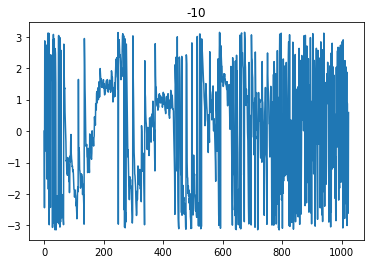

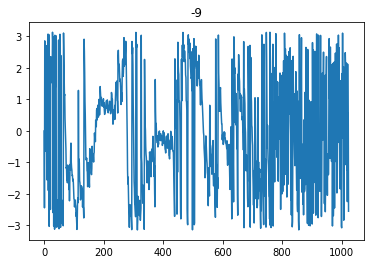

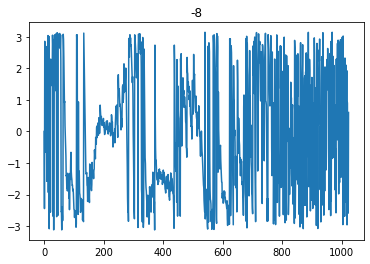

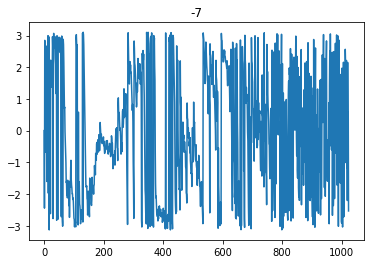

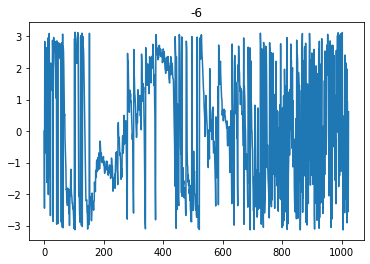

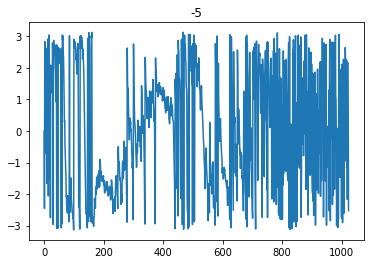

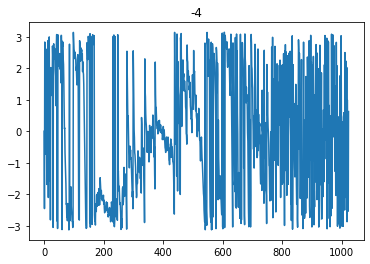

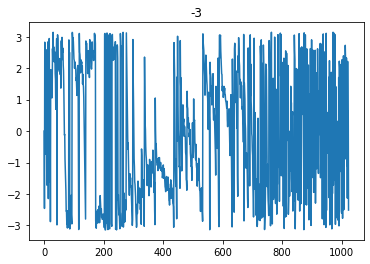

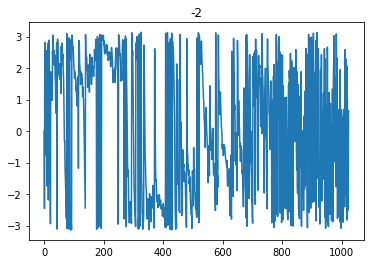

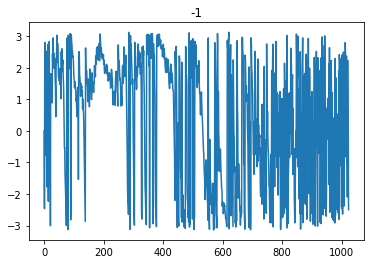

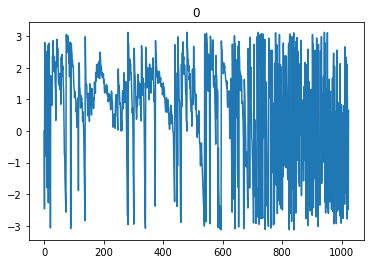

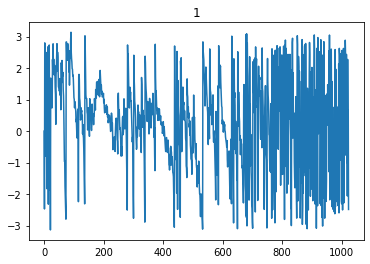

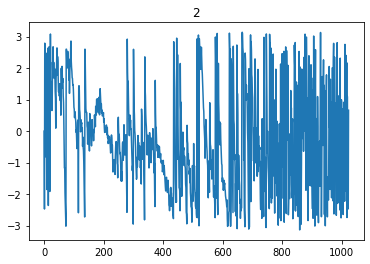

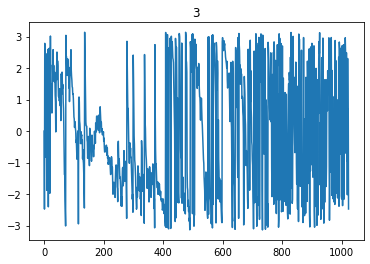

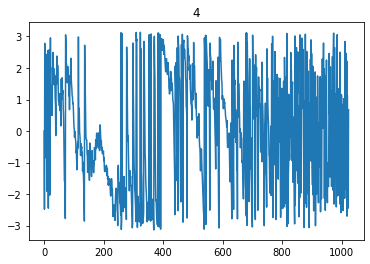

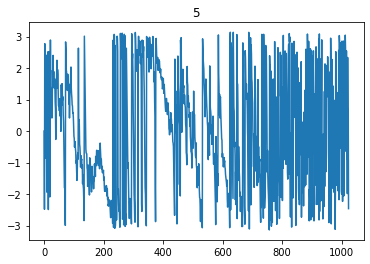

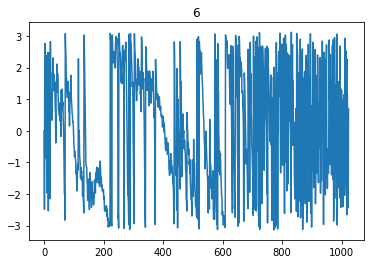

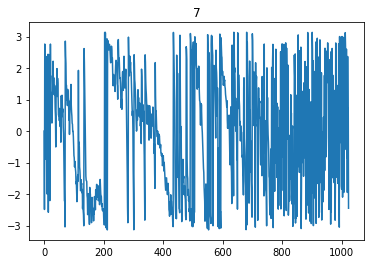

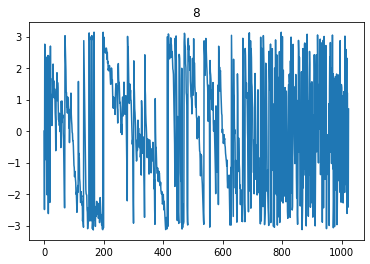

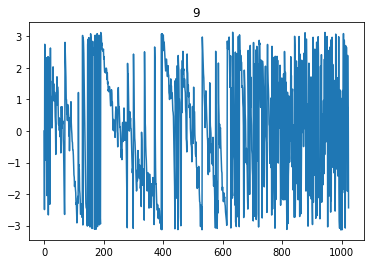

In [262]:
for i in range(20):
    freq = []
    ind = -10+i
    for sample in CE_samples:
        np.roll(sample, -1)
        freq.append( fft( np.roll(sample, ind) ) )


    CE_time_adjusted_freq = np.array(freq)
    impulse_simple_by_eye, TF_by_eye = getImpulseSimple(CE_time_adjusted_freq, known_freq, len(CE_freq[0]), len(CE_freq))

    ph_by_eye = getPhase2(TF_by_eye)
    
    print(i, end= '')
    plot_y(ph_by_eye, f= i, title = str(ind))


In [263]:
def getPhase2(TF):
    Phase = [0]
    for i in range(1, int( len(TF)/2 )-1):
        Phase.append(cmath.phase(  TF[i]  ))
    
    return np.asarray(Phase)

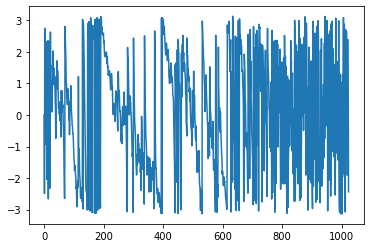

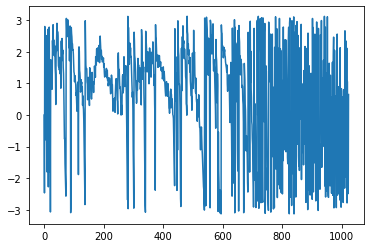

In [264]:
ph_by_eye = getPhase2(TF_by_eye)
ph        = getPhase2(TF)

plot_y(ph_by_eye)#[516:600])
plot_y(ph, f= 1)

8


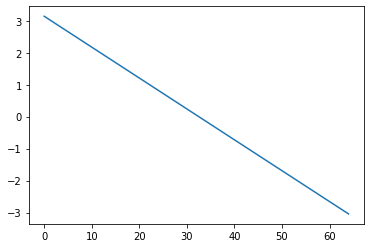

In [265]:
input_array = ph_by_eye[300:800]
corr = []
lines = []
for i in range(1, 1024):
    grad = -2*math.pi*i/2048
    
    line = []
    for j in range(10000):
        y = grad*j + math.pi
        
        if y > -1*math.pi:
            line.append(y)
        else:
            break
    corr.append(max(np.correlate(input_array, line)))
    lines.append(line)
    
#plot_y(corr)
plot_y(lines[31])
print(np.argmax(corr))

In [266]:
import sounddevice as sd

samplerates = 32000, 44100, 48000, 96000, 128000
device = 1

supported_samplerates = []
for fs in samplerates:
    try:
        sd.check_output_settings(device=device, samplerate=fs)
    except Exception as e:
        print(fs, e)
    else:
        supported_samplerates.append(fs)
print(supported_samplerates)

[32000, 44100, 48000, 96000, 128000]


In [270]:
decode(200, len(CE_freq), impulse_simple, 1)

IndexError: invalid index to scalar variable.

In [207]:
import sounddevice as sd

samplerates = 32000, 44100, 48000, 96000, 128000
device = 0

supported_samplerates = []
for fs in samplerates:
    try:
        sd.check_input_settings(device=device, samplerate=fs)
    except Exception as e:
        print(fs, e)
    else:
        supported_samplerates.append(fs)
print(supported_samplerates)

[32000, 44100, 48000, 96000, 128000]


In [224]:
from scipy.io.wavfile import read as read_wav
import os
 # change to the file directory
sampling_rate, data=read_wav("KisekiTesting/AudioFiles/chirp_signal_4.wav") # enter your filename
print (sampling_rate)

44100
